In [1]:
import numpy as np
import json
import os
import sys
from sympy import sympify
import re
import copy
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, "../src/utils/")
from agent import Environment
from text2equation import resolve_equations
from Q_learning import QLearningTrainer

Reinforcement Learning (RL) is a type of machine learning paradigm where an agent learns to make decisions by interacting with an environment. The agent learns to achieve a goal or maximize a notion of cumulative reward through trial and error. In RL, an agent takes actions in an environment, receives feedback in the form of rewards or penalties, and then uses this information to adjust its future behavior.

The library automatizes RL for custom systems. The jupyter notebook explains how to use it and the different inputs.

Lets define the environment (system) with which the agent interacts. It could be a physical system or a virtual one. In this example we model a water reservoir. We want to open or close a pipe to mantain the water level to a specific value.

In [2]:
agent = Environment("../input/mono_agent.json")

# Input

The JSON file contains various fields used as input for the script, defining both environment parameters and system rules.

To view the raw file, you can use the argumen**t agent.js**on. The field names can be accessed using the command line agent.json.keys().

Note: Fields that begin with "_" are considered as comme






## states_variables and  trigger_variables

reinforcement leaning can be viewed as a Markof Decision Process. Before to begin train, we must define different variables type.

**states_variables** are features that will be used as coordinates. The state provides the necessary information for the agent to decide what action to take.In other hands, **trigger_variables** are features that are modified by an agent. 

NB: states_variables can include feature present in **trigger_variables** list.

## initial_values

In [3]:
agent.json["initial_values"]

{'X1': [0.0], 'U1': [0.0]}

This field countains variables (and their initial value) that define our system.

## limit

In [4]:
agent.json["limit"]

{'X1': [0.0, 10.0, 11], 'U1': [0.0, 1.0, 2]}

This fied specified limit system and how it is discretized.
Each variable has a list with 3 argument:

-minimum value

-maximum value

-number of bins

# n_action

n_action is a dictionary specifying the decisions that agents can make. In this example 2 actions are possible




In [5]:
agent.json["n_action"]

{'U1': {'0': 0.0, '1': 1.0}}

## action_to_take

the field countains equations that model the agent after it took its decision. Equations are solved by using sympy library. Because we convert string to symboloic equation, it is important to delimiter variable. By default delimiter is $. 

You can change default delimiter during the initilisation:

agent = Environment(json_file, delimiter = "Char_you_want")

In [6]:
agent.json["action_to_take"]

{'U1': {'$U1$': '$action$'}}

## equations_variables

In [7]:
agent.json["equations_variables"]

{'$l$': '10.0',
 '$target$': '5.0',
 '$dX1$': '1 - $U1$ - ($X1$ - $target$)/$l$',
 '$X1$': '$X1$ + $dX1$',
 '$U1$': '$U1$'}

## equations_rewards

The reward indicates the immediate benefit or cost associated with the action.
The scalar feedback signal that the environment sends to the agent after it takes an action are defined into this dictionnary.

NB: "\$target\$" is not a agent but a temporary variable. Its value is used in the reward of the agent "\$U1\$" 

In [8]:
agent.json["equations_rewards"]

{'$target$': '5.0', '$U1$': '-1 * ($X1$ - $target$)^2'}

# Reinforcemet learning

After load our environment, next step is to create QLearningTrainer objet. It will apply Qlearning algorithm. For each states, the algorithm will apply a score base to the next iteration.

The Bellman equation is the value function use in reinforcement learning. 

$v(s) = (1−\alpha) * V(s)+ \alpha * (R+\gamma * V(s'))$

Where:

* $V(s)$ is the estimated value of state $s$ * $s$ is the curent state
* $s'$ is the next state.
* $R$ is the immediate reward received after transitioning from state $s$ to state
* $\gamma$ is the discount factor, which determines the importance of future rewards.
* $\alpha$ is the learning rate.
s.l difference (TD) learning methods.

In [9]:
RL = QLearningTrainer(agent)

Different parameters are avaible. For the tutorial, you use default parameters. Before to lunch training. Lets discus about the input parameters.

## Learning rate ($\alpha$)

The learning rate $\alpha$ in the Bellman equation controls the weight given to the new estimate compared to the existing estimate of the state value. A smaller learning rate means that the new estimate has less influence, and the agent is more conservative in updating its value function. A larger learning rate allows the agent to adjust its estimates more rapidly based on new information

## Discount factor ($\gamma$)

## Epsilon ($\epsilon$) parameter 

Exploration-exploitation is a fundamental trade-off in reinforcement learning, where the agent needs to balance between exploring new actions and exploiting the knowledge it has gained so far.

The epsilon-greedy policy is a simple strategy that the agent uses to decide whether to explore a new action (random exploration) or exploit the current best-known actionIt helps prevent the agent from getting stuck in suboptimal policies by occasionally trying new actions. The value of epsilon determines the probabilty the agent chooses a random action. A higher epsilon encourages more exploration, while a lower epsilon emphasizes exploitation of the current best-known actions.ent knowledge.

The epsilon parameter is decayed over time during training. This means that, as the agent gains more experience, it tends to rely more on exploitation and less on exploration. The idea is that, as the agent learns and becomes more confident in its estimates, it gradually reduces the rate of exploration. 

Epsilon initailization is made with the argument **exploration_prob**. It is a list with the lowest and the highest probability values. The probability will decrease with a rate given by the argument **decrease_prob_exp**. By default epsilon is modeled with a linear decay but you can change it to a exponential decay.

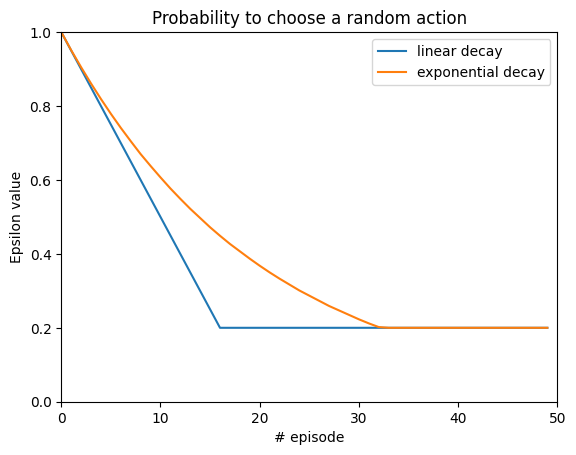

In [10]:
plt.plot(RL.give_epsilon(), label = "linear decay")
plt.plot(RL.give_epsilon(decay_type = 'exponential'), label = "exponential decay")
plt.title("Probability to choose a random action")
plt.legend()
plt.xlabel("# episode")
plt.ylim([0, 1])
plt.xlim([0, len(RL.give_epsilon())])
plt.ylabel("Epsilon value")
plt.show()

# num_episodes, run_limit and convergence_criterion

The last three options are hyperparameters. They impact computation time. **num_episodes** is the maximum number of epochs used for training. **run_limit** controls the maximum number of iterations before stopping one episode. **convergence_criterion** is the threshold (difference score between two iterations) to determine convergence.

# Train


Before training, let's adjust some parameters to reduce computation time We fix number of episode to 40, convergence_criterion to 0.01 (instead of 0.001) and change decay_type to exponential.

In [11]:
RL = QLearningTrainer(agent, num_episodes = 30, convergence_criterion = 0.01, decay_type = "exponential")

In [12]:
RL.q_learning()

Episode 1/30
exploration_prob : 1.000


C:\Users\jayse\Desktop\reinforcement_learning\RL_engine\notebook\../src/utils\Q_learning.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2.025]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.q_table.loc[
C:\Users\jayse\Desktop\reinforcement_learning\RL_engine\notebook\../src/utils\Q_learning.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93025]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.q_table.loc[


end while loop iteration :  112
Episode 2/30
exploration_prob : 0.951
end while loop iteration :  175
Episode 3/30
exploration_prob : 0.905
end while loop iteration :  123
Episode 4/30
exploration_prob : 0.861
end while loop iteration :  170
Episode 5/30
exploration_prob : 0.819
end while loop iteration :  231
Episode 6/30
exploration_prob : 0.779
end while loop iteration :  154
Episode 7/30
exploration_prob : 0.741
end while loop iteration :  101
Episode 8/30
exploration_prob : 0.705
end while loop iteration :  209
Episode 9/30
exploration_prob : 0.670
end while loop iteration :  147
Episode 10/30
exploration_prob : 0.638
end while loop iteration :  206
Episode 11/30
exploration_prob : 0.607
end while loop iteration :  193
Episode 12/30
exploration_prob : 0.577
end while loop iteration :  102
Episode 13/30
exploration_prob : 0.549
end while loop iteration :  111
Episode 14/30
exploration_prob : 0.522
end while loop iteration :  123
Episode 15/30
exploration_prob : 0.497
end while loop

To verify the proper convergence of our model, we can visualize the number of interactions for each episode. This number is expected to decrease over time as the agent gains more knowledge.

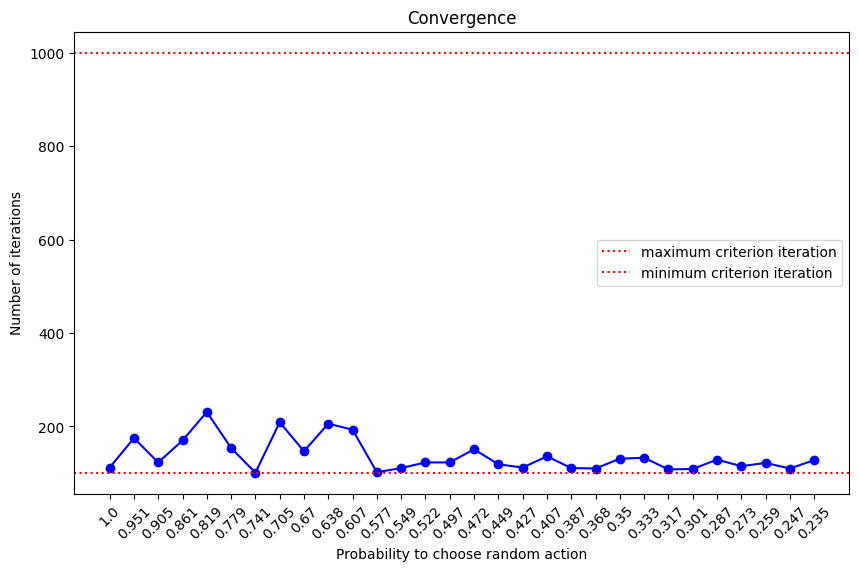

In [13]:
RL.plot_convergence()

In [14]:
RL.q_table

U1           
                   0          1
([0.0],)  -14.852250 -16.199899
([2.0],)   -2.425998  -3.352231
([3.0],)   -1.046374  -2.365483
([4.0],)   -0.643688  -0.614534
([5.0],)  -11.730173  -1.058257
([6.0],)  -20.036004 -14.608736
([7.0],)  -44.796377 -18.517358
([8.0],)  -43.910931 -48.274129
([9.0],)  -26.129901 -41.187090
([10.0],)   0.000000 -43.369083
([1.0],)   -4.743590  -6.089804